In [2]:
import numpy as np

###############################################################################
##Defining the necessities
#Defining (n, k)
num_channels = 2
num_messages = 16
num_bits = 2
###############################################################################
##Generating the training data, one hot vectors of width num_messages
num_samples = 10000
training_data = np.zeros([num_samples, num_messages])

file = open("training_data.npy", 'wb')

for iter in range(num_samples):
    training_data[iter, int(iter/(int((num_samples+1)/num_messages)))] = 1

np.save(file, training_data)
print(training_data)
file.close()
###############################################################################
##Generating the test data, one hot vectors of width num_messages
num_samples = 5000
test_data = np.zeros([num_samples, num_messages])

file = open("test_data.npy", 'wb')

for iter in range(num_samples):
    test_data[iter, np.random.randint(num_messages)] = 1

np.save(file, test_data)
print(test_data)
file.close()


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


midlayer_dim : 10
Train on 10000 samples, validate on 5000 samples
Epoch 1/100
10000/10000 [==============================] - 1s 124us/step - loss: 2.3331 - val_loss: 1.8684
Epoch 2/100
10000/10000 [==============================] - 0s 39us/step - loss: 1.5904 - val_loss: 1.2381
Epoch 3/100
10000/10000 [==============================] - 0s 42us/step - loss: 1.1734 - val_loss: 0.9199
Epoch 4/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.9074 - val_loss: 0.7054
Epoch 5/100
10000/10000 [==============================] - 0s 39us/step - loss: 0.7199 - val_loss: 0.5245
Epoch 6/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.5842 - val_loss: 0.3999
Epoch 7/100
10000/10000 [==============================] - 0s 49us/step - loss: 0.4742 - val_loss: 0.2924
Epoch 8/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.3998 - val_loss: 0.2159
Epoch 9/100
10000/10000 [==============================] - 0s 40us/step - loss: 0.33

10000/10000 [==============================] - 0s 39us/step - loss: 0.0361 - val_loss: 5.2575e-04
Epoch 77/100
10000/10000 [==============================] - 0s 35us/step - loss: 0.0271 - val_loss: 5.1089e-04
Epoch 78/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.0359 - val_loss: 6.2890e-04
Epoch 79/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0287 - val_loss: 5.0116e-04
Epoch 80/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.0337 - val_loss: 5.3508e-04
Epoch 81/100
10000/10000 [==============================] - 0s 36us/step - loss: 0.0194 - val_loss: 5.9984e-04
Epoch 82/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.0210 - val_loss: 4.3009e-04
Epoch 83/100
10000/10000 [==============================] - 0s 38us/step - loss: 0.0557 - val_loss: 8.1899e-04
Epoch 84/100
10000/10000 [==============================] - 0s 36us/step - loss: 0.0253 - val_loss: 4.1257e-04
Epoch 85/100
1

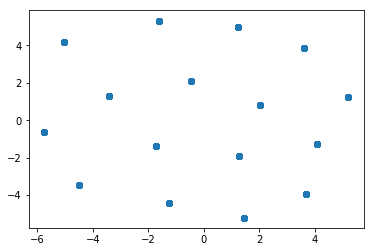

In [4]:
import keras
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam
from keras.models import Model
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

###############################################################################
file_train = open("training_data.npy", "rb")
file_test = open("test_data.npy", "rb")

training_data = np.load(file_train)
test_data = np.load(file_test)

file_train.close()
file_test.close()
###############################################################################
learning_rate = 0.001
input_dim = 16
encoding_dim = 2
midlayer_dim = int((input_dim+encoding_dim)/2) +1
print ("midlayer_dim :", midlayer_dim )
energy_per_bit = 5

input_msg = Input(shape = (input_dim, ))


encoded = Dense(input_dim, activation='relu')(input_msg)
encoded2 = Dense(encoding_dim, activation = 'linear')(encoded)
#encoded3 = keras.layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=0))(encoded2)
#encoded3 = keras.layers.Lambda(lambda x:np.sqrt(encoding_dim)*keras.backend.l2_normalize(x, axis=1))(encoded2)
encoded3 = keras.layers.BatchNormalization(axis=1)(encoded2)
encoded4 = keras.layers.GaussianNoise(np.sqrt(encoding_dim/(2*input_dim*energy_per_bit)))(encoded3)

decoded3 = Dense(midlayer_dim, activation = 'relu')(encoded4)
decoded  = Dense(input_dim, activation = "softmax") (decoded3)

adam = Adam(learning_rate)
sgd = SGD(learning_rate)

autoencoder = Model(input_msg, decoded)
autoencoder.compile(optimizer = adam, loss='categorical_crossentropy')

###############################################################################
##Preparing the encoder and the decoder
encoder = Model(input_msg, encoded3)

encoded_input = Input(shape=(encoding_dim, ))
decoder_layer1 = autoencoder.layers[-2](encoded_input)
decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
#decoder_layer3 = autoencoder.layers[-1](decoder_layer2)

decoder = Model(encoded_input, decoder_layer2)
###############################################################################

autoencoder.fit(training_data, training_data, epochs=100, batch_size=50, shuffle=True, validation_data=(test_data, test_data))
###############################################################################
test_predictions = encoder.predict(test_data)

plt.scatter(test_predictions[:, 0], test_predictions[:, 1])
plt.show()
